In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import animation

# Use retina backend for better figures
%config InlineBackend.figure_format = 'retina'


# Partial Differential Equation

Function value depends on multiple variables.

* 2nd Order linear PDE classification: hyperbolic, parabolic, elliptic
* Characteristic line/area

Different kinds of PDES can be thought having different structure for time evolving.
One point of the space is affected by points of an area(or volume). 

# Discretization and Difference

Generate a multi-dimension grid, and calculate function values
at grid points. There are different schemes for difference calculation.  
2nd order central difference of a 2-D grid:
\begin{align}
    u_{xx} &= \frac{u_{i+1, j} - 2u_{i, j} + u_{i-1, j}}{\Delta x^2} \\
    u_{yy} &= \frac{u_{i, j+1} - 2u_{i, j} + u_{i, j-1}}{\Delta y^2} \\
    u_{x} &= \frac{u_{i+1, j} - u_{i-1, j}}{2 \Delta x} \\
    u_{y} &= \frac{u_{i+1, j} - u_{i-1, j}}{2 \Delta y} \\
\end{align}

# Wave Equation(hyperbolic)

* Initial value condition 
* Reflection boundary condition
* Intermediate field $v(x)$

Wave equation, 
\begin{equation}
    \frac{\partial^2u}{\partial t^2} = c^2 \frac{\partial^2u}{\partial x^2}
\end{equation}

<IPython.core.display.Javascript object>


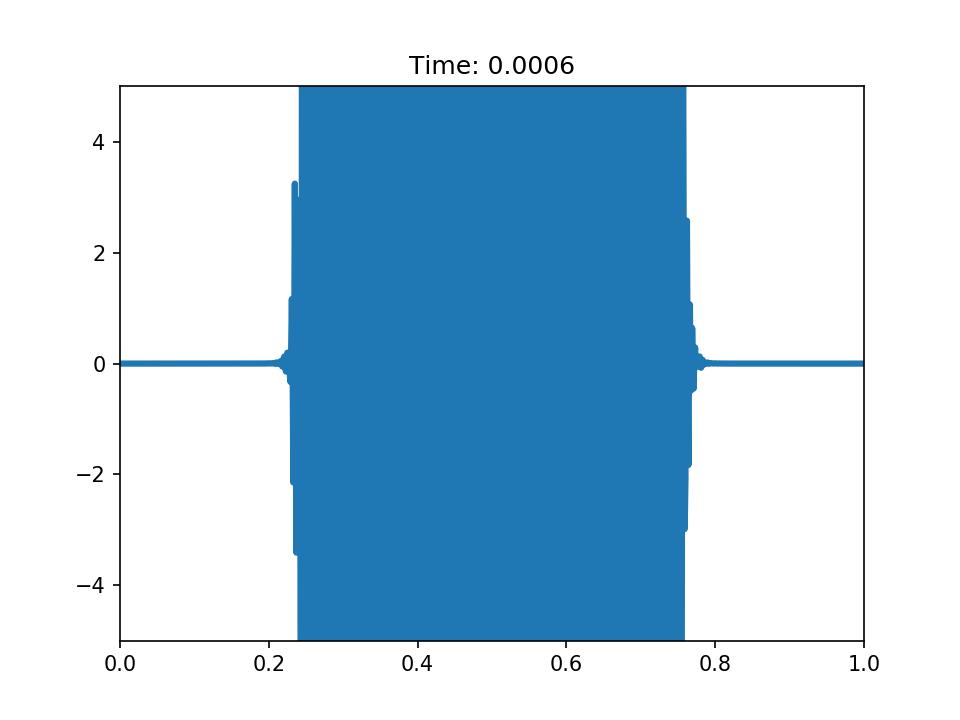

In [51]:
def pulse(x, x0, sigma):
    return np.exp(-(x - x0)**2 / sigma**2)


# Solve wave equation numerically with FTCS method
length = 1.  # Length of rope
n = 10**3 # Sample number of space position 
c = 300 # Wave velocity Unit: m/s
x0 = length / 2 # Initial pulse location
sigma = x0 / 10 # Initial pulse width
dx = 1e-3
# This method is instable for any dt
dt = 0.8 * dx / c  
t_end = 2 * length / c # Final stable solution 

x = np.arange(0, length+dx, dx)
u_prev = pulse(x, x0, sigma)
u_next = np.zeros_like(x, dtype="float")
# Introduce an intermediate field 
v_prev = np.zeros_like(x, dtype="float")
v_next = np.zeros_like(x, dtype="float")


def frame_iter():
    global u_next, u_prev, v_prev, v_next 
    t = 0
    while t <= t_end:
        u_next[1:-1] = u_prev[1:-1] + c * (v_prev[2:] - v_prev[:-2]) * dt / (2*dx)
        v_next[1:-1] = v_prev[1:-1] + c * (u_prev[2:] - u_prev[:-2]) * dt / (2*dx)
        v_next[0] = u_next[1] + v_next[1]
        v_next[-1] = v_next[-2] - u_next[-2]
        u_next[[0, -1]] = 0, 0
        ax.set_title(f"Time: {t:.4F}")
        line.set_data(x, u_prev)
        yield line, 
        # Divergent condition
        u_prev = np.copy(u_next)
        v_prev = np.copy(v_next)
        t += dt 
        

def init():
    line.set_data(x, u_prev)
    return line,

    
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=3)
ax.set_xlim(0, length)
ax.set_ylim(-5, 5)
frame = frame_iter()
update = lambda x: next(frame)
ani = animation.FuncAnimation(fig, update, init_func=init, \
                             frames=300, interval=10)


# Von Neumann Stability Analysis

A propagating wave can be thought as superposition of different
frequency plane waves of different amplitude.
\begin{align}
    e^{ik(x - ct)} =& e^{ikx}\, e^{-i\omega t} \\
    u_{m}^{0} =& e^{ikx_{m}} \\
    u_{m}^{n} =& e^{-i\omega n\Delta t} \, e^{ikx_{m}} \ \text{(exact solution)}\\
    u_{m}^{n} =& \underbrace{(1 - ic\frac{\Delta t}{\Delta x}\sin{k\Delta x})}_{\xi(k)} e^{ikx_{m}} \ \text{(FTCS numerical solution)} \\
\end{align}
In which, $|\xi(k)|^2$ is always greater than one, which brings the instability to this method. 

# Lax 

Modify FTCS recurrence expression to
\begin{equation}
    a_j^{n+1} = \frac{1}{2}(a_{j+1}^{n} + a_{j-1}^{n}) - c\frac{a_{j+1}^{n} - a_{j-1}^{n}}{2\Delta x}\Delta t
\end{equation}
Replace $a_j^{n}$ with average of neighbor points.

In [ ]:
def pulse(x, x0, sigma):
    return np.exp(-(x - x0)**2 / sigma**2)


# Solve wave equation numerically with FTCS method
length = 1.  # Length of rope
c = 300. # Wave velocity Unit: m/s
x0 = length / 2 # Initial pulse location
sigma = x0 / 10 # Initial pulse width
dx = 1e-3
# In order to maintain stability of FTCS, 
# dt <= 1 * dx^2 / D
dt = .6 * dx / c  
t_end = length / c # Final stable solution 

x = np.arange(0, length+dx, dx)
u_prev = pulse(x, x0, sigma)
u_next = np.zeros_like(x, dtype="float")
u_prev[[0, -1]] = 0, 0
# Introduce an intermediate field 
v_prev = np.zeros_like(x, dtype="float")
v_next = np.zeros_like(x, dtype="float")


def frame_iter():
    global u_next, u_prev, v_prev, v_next 
    t = 0
    while t <= t_end:
        u_next[1:-1] = (u_prev[2:] + u_prev[:-2])/2 + c * (v_prev[2:] - v_prev[:-2]) * dt / (2*dx)
        v_next[1:-1] = (v_prev[2:] + v_prev[:-2])/2 + c * (u_prev[2:] - u_prev[:-2]) * dt / (2*dx)
        v_next[0] = u_next[1] + v_next[1]
        v_next[-1] = v_next[-2] - u_next[-2]
        u_next[[0, -1]] = 0, 0
        ax.set_title(f"Time: {t:.4F}")
        line.set_data(x, u_prev)
        yield line, 
        # Divergent condition
        u_prev = np.copy(u_next)
        v_prev = np.copy(v_next)
        # Convergent condition
        # This condition is valid because  
        # u_prev = u_next
        # v_prev = v_next
        t += dt 
        

def init():
    line.set_data(x, u_prev)
    return line,

    
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=3)
ax.set_xlim(0, length)
ax.set_ylim(-5, 5)
frame = frame_iter()
update = lambda x: next(frame)
ani = animation.FuncAnimation(fig, update, init_func=init, \
                             frames=300, interval=10)


# Leapfrog Scheme

<IPython.core.display.Javascript object>


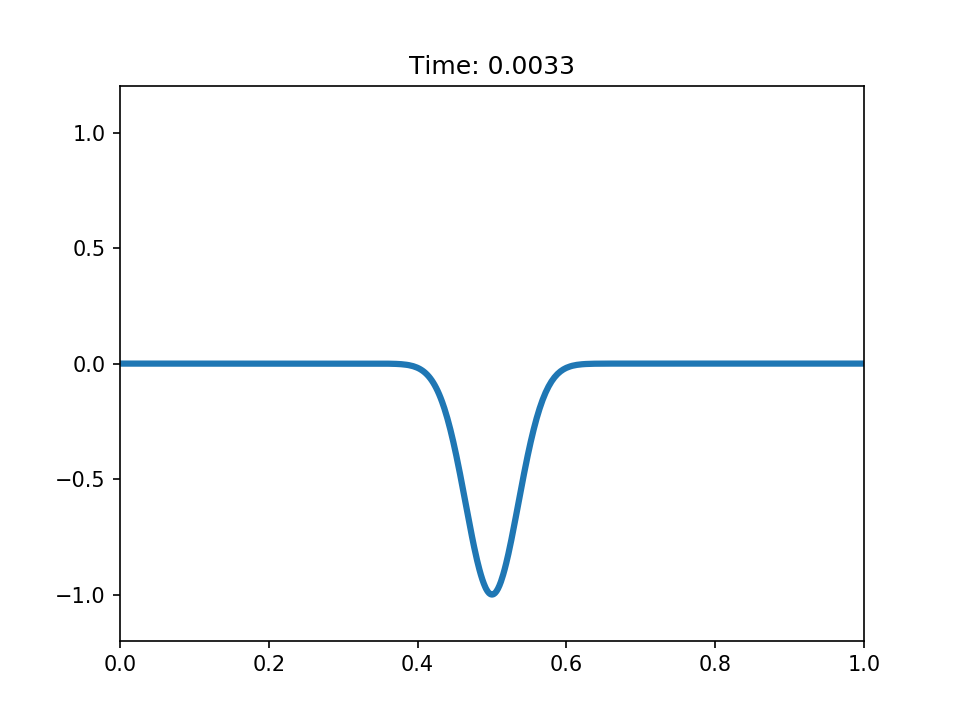

In [49]:
def pulse(x, x0, sigma):
    return np.exp(-(x - x0)**2 / sigma**2)


# Solve wave equation numerically with FTCS method
length = 1.  # Length of rope
c = 300. # Wave velocity Unit: m/s
x0 = length / 2 # Initial pulse location
sigma = x0 / 10 # Initial pulse width
dx = 1e-3
# In order to maintain stability of FTCS, 
# dt <= 1/2 * dx^2 / D
dt = .6 * dx / c  
t_end = length / c # Final stable solution 

x = np.arange(0, length+dx, dx)
u = pulse(x, x0, sigma)
u[[0, -1]] = 0, 0
# Introduce an intermediate field 
v = np.zeros_like(x, dtype="float")


def frame_iter():
    global u, u, v, v 
    t = 0
    while t <= t_end:
        u[1:-1] = u[1:-1] + c * (v[2:] - v[:-2]) * dt / (2*dx)
        # u have been updated, u = u(t=t+dt)
        # v is calculated with u(t+dt) 
        v[1:-1] = v[1:-1] + c * (u[2:] - u[:-2]) * dt / (2*dx)
        v[0] = u[1] + v[1]
        v[-1] = v[-2] - u[-2]
        u[[0, -1]] = 0, 0
        ax.set_title(f"Time: {t:.4F}")
        line.set_data(x, u)
        yield line, 
        t += dt 
        

def init():
    line.set_data(x, u)
    return line,

    
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=3)
ax.set_xlim(0, length)
ax.set_ylim(-1.2, 1.2)
frame = frame_iter()
update = lambda x: next(frame)
ani = animation.FuncAnimation(fig, update, init_func=init, \
                             frames=300, interval=10)


# Heat Equation (parabolic)

Heat equation represents a general catalog of PDE called diffusion equation,
which describes how the density of particles evolve along time.
\begin{equation}
    \frac{\partial \phi (\mathbf{r} ,t)}{\partial t}=D\nabla ^{2}\phi (\mathbf{r} ,t),
\end{equation}

# FTCS

<IPython.core.display.Javascript object>


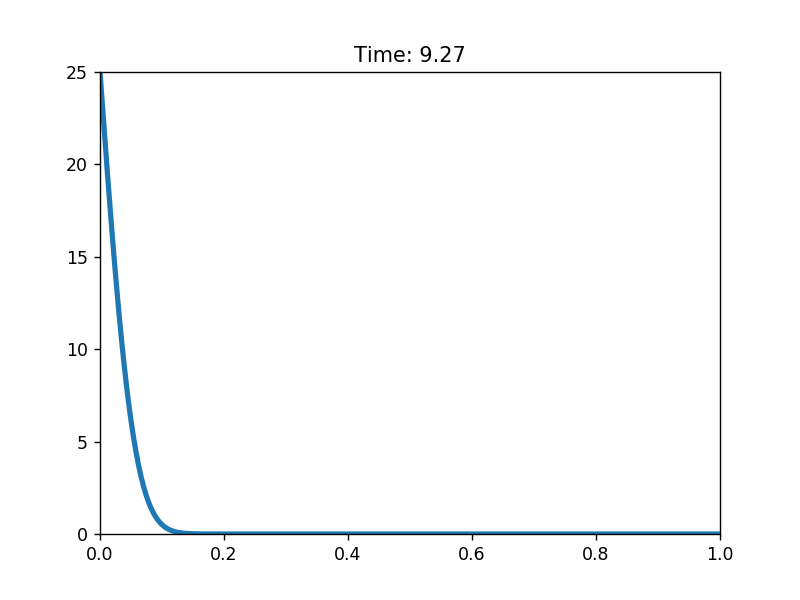

In [62]:
# Solve heat equation numerically with FTCS method
length = 1.  # Length of bar
n = 10**3
D = 1e-4
# In order to maintain stability of FTCS, 
# dt <= 1/2 * dx^2 / D
dt = 0.5 * dx**2 / D 
t_end = 20 * length**2 / D # Final stable solution 

x = np.linspace(0, length, n+1)
temp_now = np.zeros_like(x, dtype="float")
temp_now[[0, -1]] = 25, 0  # Initial condition 
temp_next = np.zeros_like(x, dtype="float")


def frame_iter():
    global temp_next, temp_now
    t = 0
    while t <= t_end:
        temp_next[1:-1] = temp_now[1:-1] + dt * D \
                    * (temp_now[2:] - 2 * temp_now[1:-1] + temp_now[0:-2])\
                    / dx**2 
        temp_next[[0, -1]] = 25, 0
        temp_now = temp_next
        ax.set_title(f"Time: {t:.2F}")
        line.set_data(x, temp_now)
        yield line, 
        t += dt 
        

def init():
    line.set_data(x, temp_now)
    return line,
    
    
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=3)
ax.set_xlim(0, length)
ax.set_ylim(0, 25)
frame = frame_iter()
update = lambda x: next(frame)
ani = animation.FuncAnimation(fig, update, init_func=init, \
                             frames=300, interval=1)


# Implicit Differencing Scheme(BTCS)

FTCS has a obvious disadvantage, dt cannot be greater than $dx^2 /2 D$, which means for the same end time, it takes more steps($N\approx (L/\Delta x)^2$ for heat equation) and time. If we replace central difference of time with forward difference, we can have a more efficient method for computing such kind of problems.
BTCS algorithm has absolute stability and it converts integration problem into dealing with a size-n linear system.  
BTCS method(Calculate $u_{xx}$ at time $t_n$ with new $u$ values at next time.):
\begin{equation}
    u_{xx}^{n} = \frac{u_{j+1}^{n+1} - u_{j}^{n+1} + u_{j-1}^{n+1}}{\Delta x^2}
\end{equation}  
Stability analysis:  
\begin{equation}
    \xi (k) = \frac{1}{1 + 4 \frac{D\Delta t}{\Delta x^2} \sin(\frac{k\Delta x}{2})}
\end{equation}
We can see no matter what $\Delta x$ and $\Delta t$ are, this method is always stable. So we can choose larger step in time.  
According to above equation, we have established recurrence relationship between $u_{n+1}$ and $u_{n}$, namely, 
\begin{equation}
    \alpha u_{j+1}^{n+1} + \beta u_{j}^{n+1} + \gamma u_{j-1}^{n+1} = u_j^{n}
\end{equation}
When updating $u_j$, we need to solve a linear system, which is the problem that we've already worked on.

<IPython.core.display.Javascript object>


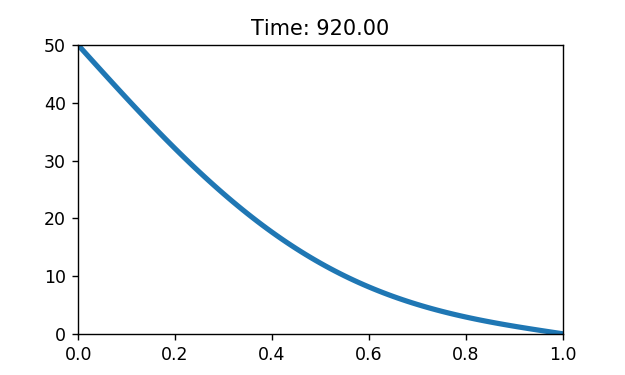

In [18]:
def gauss_solver_band(band):
    """
    Solve linear system in band matrix form with Gauss method
    
    band: coefficient matrix with shape(n, n+1), n equals
                 number of variables. The last column is the right 
                 side of equations.
 
    return array of solution
    """
    coefficient = band.copy()
    # number of variables 
    dimension = coefficient.shape[0]
    varibles = np.zeros(dimension)

    for i in range(dimension-1):
        coefficient[i] = coefficient[i] / coefficient[i, i]
        coefficient[i+1] = coefficient[i+1] - coefficient[i+1, i] * coefficient[i]
    coefficient[-1] = coefficient[-1] / coefficient[-1, -2]
    
    # Solve xi in reverse order
    varibles[-1] = coefficient[-1, -1] 
    for i in range(-2, -dimension - 1, -1):
        # Be carefull when using negative index, because that's related to array's shape!
        varibles[i] = coefficient[i, -1] - coefficient[i,i] * varibles[i+1]
   
    return varibles


temp0, temp1 = 50, 0
length = 1. # Unit: m
D = 1e-4
dx = 1e-2
dt = 10 * dx**2 / D 
t_end = length**2 / D
x = np.arange(0, length+dx, dx)
nx = len(x)
alpha = gamma = - D * dt / dx**2
beta = 1 + 2 * D * dt / dx**2 

# Construct band matrix 
temp_prev = np.zeros_like(x, dtype="float")
temp_prev[[0, -1]] = temp0, temp1
temp_next = np.zeros_like(x, dtype="float")
boundary = np.zeros(nx-2, dtype="float")
boundary[[0, -1]] = alpha * temp0, gamma * temp1
coe = np.zeros((nx-2, nx-1), dtype="float")
coe[:, -1] = temp_prev[1:-1] - boundary
np.fill_diagonal(coe, beta)
np.fill_diagonal(coe[1:], alpha)
np.fill_diagonal(coe[:,1:], gamma)

def frame_iter():
    global temp_next, temp_prev
    t = 0
    while t <= t_end:
        coe[:, -1] = temp_prev[1:-1] - boundary
        temp_next[1:-1] = gauss_solver_band(coe)
        temp_next[[0, -1]] = temp0, temp1
        temp_prev = temp_next
        ax.set_title(f"Time: {t:.2F}")
        line.set_data(x, temp_next)
        yield line, 
        t += dt 
        

def init():
    line.set_data(x, temp_prev)
    return line,
    

frame = frame_iter()
update = lambda x: next(frame)
    
fig, ax = plt.subplots(figsize=(5, 3))
line, = ax.plot([], [], lw=3)
ax.set_xlim(0, length)
ax.set_ylim(0, 50)
ani = animation.FuncAnimation(fig, update, init_func=init, \
                             frames=300, interval=100)


# Laplace Equation & Poisson Equation(elliptic) 

\begin{equation}
    \frac{\partial u^2(x, y, z)}{\partial x^2} + \frac{\partial u^2(x, y, z)}{\partial y^2} + \frac{\partial u^2(x, y, z)}{\partial z^2} = 0
\end{equation}

\begin{equation}
    \frac{\partial u^2(x, y, z)}{\partial x^2} + \frac{\partial u^2(x, y, z)}{\partial y^2} + \frac{\partial u^2(x, y, z)}{\partial z^2} = f(x, y, z)
\end{equation}

# Relaxation Method

Philosophy of relaxation method is like gradient-descent method in
minimum searching. First, set a arbitrary(initial guess) function $u$,
then update this function by the recurrence below
\begin{equation}
    \frac{\partial u}{\partial t} = \hat{L}u - \rho
\end{equation}
in which $\hat{L}$ is the differential operator and $\rho$ is suource function of Poisson equation.   
For a 2-D Laplace problem, 
\begin{equation}
     \frac{\partial u^2(x, y, z)}{\partial x^2} + \frac{\partial u^2(x, y, z)}{\partial y^2} = 0
\end{equation}
With FTCS difference scheme, discrete form of above equation is
\begin{equation}
    u_{j,k}^{n+1} = u_{j,k}^{n} + \left[\frac{u_{i+1, j} - 2u_{i, j} + u_{i-1, j}}{\Delta x^2} + \frac{u_{i, j+1} - 2u_{i, j} + u_{i, j-1}}{\Delta y^2}\right] \Delta t
\end{equation}
And the recurrence relation
\begin{equation}
    u_{j,k}^{n+1} = (1-\omega)u_{j,k}^{n} + \frac{\omega}{4}(u_{j+1,k}^{n} + u_{j,k+1}^{n} + u_{j-1,k}^{n} + u_{j,k-1}^{n})
\end{equation}
In order to maintain stability, we must have some limits of $\omega$, which means in this case
omega should be no greater than 1.  
For case $\omega =1$, this is also called Jacobi algorithm.
\begin{equation}
    u_{j,k}^{n+1} = \frac{1}{4}(u_{j+1,k}^{n} + u_{j,k+1}^{n} + u_{j-1,k}^{n} + u_{j,k-1}^{n})
\end{equation}

In [60]:
%%HTML
<a><img src="https://s2.ax1x.com/2019/04/27/EMCYZD.md.png" alt="relax_example.png" border="0" width=350px /></a>

<IPython.core.display.Javascript object>


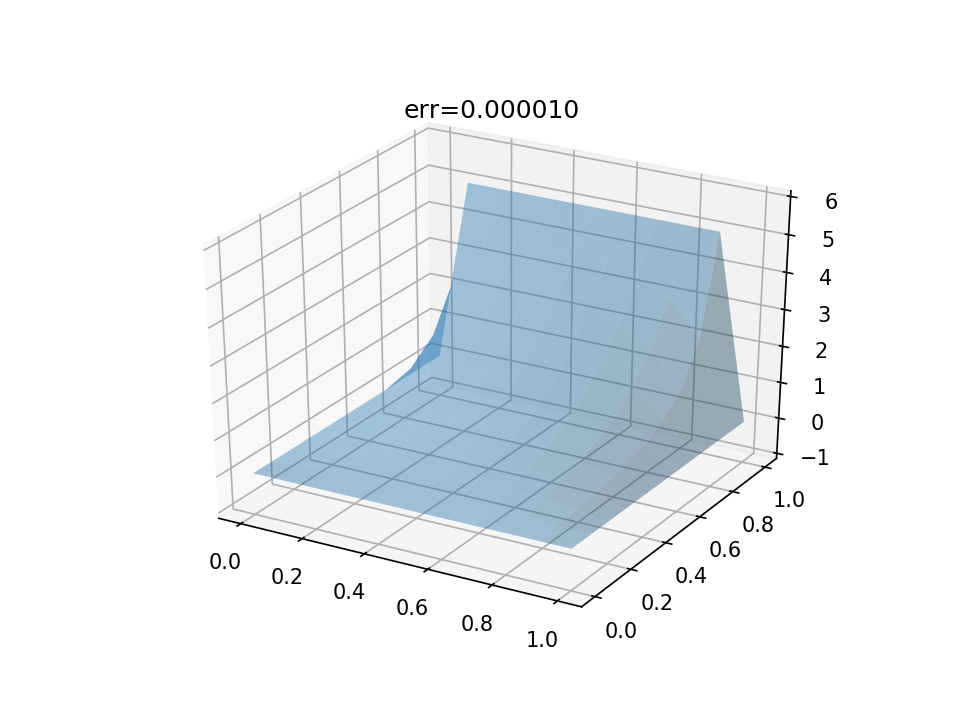

In [94]:
from mpl_toolkits.mplot3d import Axes3D
# Calculate electrostatic potential of a 2x2 square with given boundary condition 
omega = 1.
v0 = 5 # Unit: Volts
tol = 1e-5
dy = dx = 1e-1
length = 1. # length of square to be solved
x = np.arange(0, length+dx, dx)
y = np.arange(0, length+dy, dy)
xx, yy = np.meshgrid(x, y)
# Create 2-D array to store potential value
u_prev = np.zeros_like(xx, dtype="float")
u_next = np.zeros_like(xx, dtype="float")
# Set boundary condition, note for the orientation of meshgrid  
u_prev[0,:] = 0 # y=0 boundary
u_prev[-1,:] = v0 # y=L boundary
u_prev[:, 0] = 0 # x=0 boundary
u_prev[:, -1] = 0 # x=L boundary
u_next[0,:] = 0 # y=0 boundary
u_next[-1,:] = v0 # y=L boundary
u_next[:, 0] = 0 # x=0 boundary
u_next[:, -1] = 0 # x=L boundary

def frame_iter():
    global u_prev, u_next
    err = 1 
    while err > tol:
        u_next[1:-1,1:-1] = (u_prev[1:-1,:-2] + u_prev[1:-1,2:] + u_prev[:-2,1:-1] +  u_prev[2:,1:-1]) / 4
        ax.clear()
        ax.set_title(f"err={err:.6F}")
        sur = ax.plot_surface(xx, yy, u_next, alpha=0.4)
        ax.set_zlim(-1, 6)
        # con.set_data(xx, yy, u_prev)
        yield sur
        err = np.mean(abs(u_next - u_prev))  
        u_prev = np.copy(u_next)

    
        
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
sur = ax.plot_surface(xx, yy, u_prev, alpha=0.4)
# con = ax.contour(xx, yy, u_prev, zdir='z')
_frame = frame_iter()
frame_gen = lambda i: next(_frame)
ani = animation.FuncAnimation(fig, frame_gen, interval=10)


# Over-relaxation Method (SOR)

There is a shortcome of relaxation method, that the time it takes to
converge is a little bit long. And over-relaxation method can partly solve
this issue. We will do a division on all grid points we will calculate.  

* For integer points(CataI), update these points with CataII points.  
* For half-integer points(CataII), update these points with CataI points.  

For integer points, we have
\begin{equation}
    u_{j,k}^{n+1} = (1-\omega)u_{j,k}^{n} +\frac{\omega}{4}(u_{j+1,k}^{n+1/2} + u_{j,k+1}^{n+1/2} + u_{j-1,k}^{n+1/2} + u_{j,k-1}^{n+1/2})
\end{equation}
Through stability analysis, the convergent range of $\omega$ is 0~2. So if $\omega>1$,
we have speeded up the relaxation method.

<IPython.core.display.Javascript object>


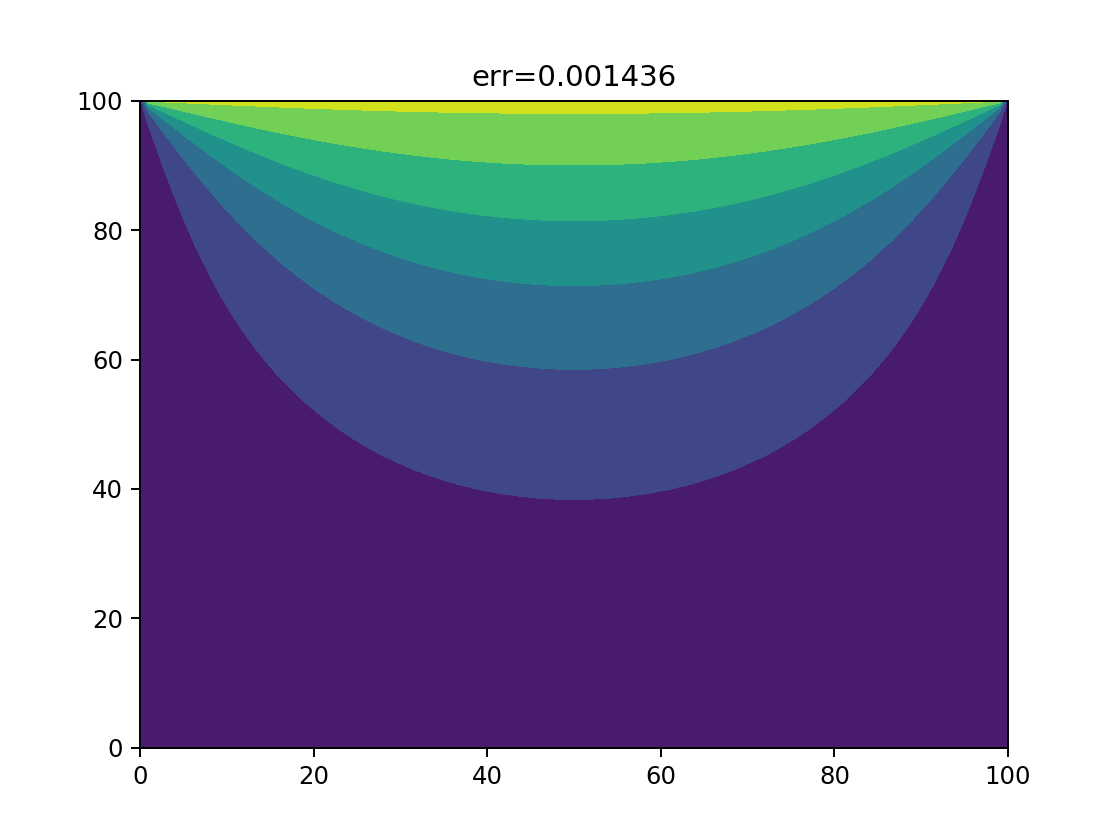

In [79]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

# Calculate electrostatic potential of a 2x2 square with given boundary condition
v0 = 5  # Unit: Volts
tol = 1e-5
dy = dx = 1e-2
length = 1.  # length of square to be solved
omega = 2. / (1 + np.sin(dx / length * np.pi))
x = np.arange(0, length + dx, dx)
y = np.arange(0, length + dy, dy)
xx, yy = np.meshgrid(x, y)
# Create 2-D array to store potential value
u_next = np.zeros_like(xx, dtype="float")  # Half-int points
# Set boundary condition, note for the orientation of meshgrid
u_next[0, :] = 0  # y=0 boundary
u_next[-1, :] = v0  # y=L boundary
u_next[:, 0] = 0  # x=0 boundary
u_next[:, -1] = 0  # x=L boundary


def frame_iter():
    global u_next
    err = 1
    while err > tol:
        _temp_u = np.copy(u_next)
        # Black points PartI
        u_next[1:-1:2, 1:-1:2] = (1 - omega) * u_next[1:-1:2, 1:-1:2] + omega / 4 \
                                * (u_next[0:-1:2, 1::2] + u_next[2::2, 1::2] \
                                   + u_next[1::2, :-1:2] + u_next[1::2, 2::2])

        # Black points PartII
        u_next[2:-1:2, 2:-1:2] = (1 - omega) * u_next[2:-1:2, 2:-1:2] + omega / 4 \
                                * (u_next[2:-1:2, 1:-2:2] + u_next[2:-1:2, 3:-1:2] \
                                + u_next[1:-2:2, 2:-1:2] + u_next[3:-1:2,2:-1:2])

        # White points PartI
        u_next[2:-1:2, 1:-1:2] = (1 - omega) * u_next[2:-1:2, 1:-1:2] + omega / 4 \
                                * (u_next[2:-1:2, :-2:2] + u_next[2:-1:2, 2::2] \
                                   + u_next[1:-2:2, 1:-1:2] + u_next[3::2,1:-1:2])

        # White points PartII
        u_next[1:-1:2, 2:-1:2] = (1 - omega) * u_next[1:-1:2, 2:-1:2] + omega / 4 \
                                * (u_next[1:-1:2, 1:-2:2] + u_next[1:-1:2, 3::2] \
                                   + u_next[0:-2:2, 2:-1:2] + u_next[2::2,2:-1:2])
        ax.clear()
        err = np.mean(abs(u_next - _temp_u))
        ax.set_title(f"err={err:.6F}")
        sur = ax.contourf(u_next)

        yield sur,


fig, ax = plt.subplots()
sur = ax.contourf(xx, yy, u_next, alpha=0.4)
_frame = frame_iter()
frame_gen = lambda i: next(_frame)
ani = animation.FuncAnimation(fig, frame_gen, interval=100, blit=False)


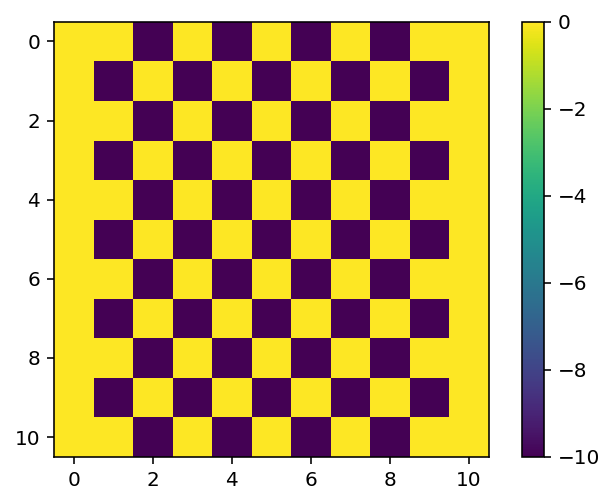

In [73]:
u_next = np.zeros_like(u_next) 

# u_next[1:-1:2,1:-1:2] = 10
# u_next[0:-1:2,1::2] = -10 # upper points
# u_next[2::2,1::2] = -10 # lower points
# u_next[1::2,:-1:2] = -10 # left points 
# u_next[1::2,2::2] = -10 # right points    

# u_next[1:-1:2,1:-1:2] = u_next[1:-1:2,1:-1:2] + 1/4\
#                         * (u_next[0:-1:2,1::2] + u_next[2::2,1::2]\
#                           + u_next[1::2,:-1:2] + u_next[1::2,2::2])

# u_next[2:-1:2,2:-1:2] = 10
# u_next[2:-1:2,1:-2:2] = -10  # left 
# u_next[2:-1:2,3:-1:2] = -10 # right
# u_next[1:-2:2,2:-1:2] = -10 # upper
# u_next[3:-1:2,2:-1:2] = -10 # lower
# u_next[2:-1:2,2:-1:2] = u_next[2:-1:2,2:-1:2] + 1/4\
#                         * (u_next[2:-1:2,1:-2:2] + u_next[2:-1:2,3:-1:2]\
#                           + u_next[1:-2:2,2:-1:2] + u_next[3:-1:2,2:-1:2])

# u_next[2:-1:2,1:-1:2] = 10
# u_next[2:-1:2,:-2:2] = -10 # left
# u_next[2:-1:2,2::2] = -10 # right
# u_next[1:-2:2,1:-1:2] = -10 # upper
# u_next[3::2,1:-1:2] = -10 # lower
# u_next[2:-1:2,1:-1:2] = u_next[2:-1:2,1:-1:2] + 1/4\
#                         * (u_next[2:-1:2,:-2:2] + u_next[2:-1:2,2::2]\
#                           + u_next[1:-2:2,1:-1:2] + u_next[3::2,1:-1:2])

u_next[1:-1:2,2:-1:2] = 10
u_next[1:-1:2,1:-2:2] = -10 # left
u_next[1:-1:2,3::2] = -10 # right
u_next[0:-2:2,2:-1:2] = -10 # upper
u_next[2::2,2:-1:2] = -10 # lower
u_next[1:-1:2,2:-1:2] = u_next[1:-1:2,2:-1:2] + 1/4\
                        * (u_next[1:-1:2,1:-2:2] + u_next[1:-1:2,3::2]\
                          + u_next[0:-2:2,2:-1:2] + u_next[2::2,2:-1:2])

plt.imshow(u_next)
plt.colorbar()